## Flight delay data preprocessing and analysis

**1. Data Downloading**

In [1]:
import kagglehub

path = kagglehub.dataset_download("hrishitpatil/flight-data-2024")

print("Downloaded to:", path)


/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Downloaded to: /home/adam/.cache/kagglehub/datasets/hrishitpatil/flight-data-2024/versions/2


In [2]:
from pathlib import Path
import shutil

data_folder = Path('../data')
data_folder.mkdir(exist_ok=True)

for f in Path(path).glob('*'):
    shutil.copy(f, data_folder / f.name)


In [3]:
import pandas as pd

df = pd.read_csv("../data/flight_data_2024.csv")

/tmp/ipykernel_26684/1157875057.py:3: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/flight_data_2024.csv")


In [4]:
df.head()

,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2024,1,1,1,2024-01-01,9E,4814.0,JFK,"New York, NY",New York,...,0,136.0,122.0,84.0,509.0,0,0,0,0,0
1,2024,1,1,1,2024-01-01,9E,4815.0,MSP,"Minneapolis, MN",Minnesota,...,0,130.0,114.0,88.0,622.0,0,0,0,0,0
2,2024,1,1,1,2024-01-01,9E,4817.0,JFK,"New York, NY",New York,...,0,106.0,90.0,61.0,288.0,0,0,0,0,0
3,2024,1,1,1,2024-01-01,9E,4817.0,RIC,"Richmond, VA",Virginia,...,0,111.0,76.0,51.0,288.0,0,0,0,0,0
4,2024,1,1,1,2024-01-01,9E,4818.0,DTW,"Detroit, MI",Michigan,...,0,79.0,70.0,45.0,237.0,0,0,0,0,0


**2. Missing values check**

In [5]:
df.isnull().sum()

year                         0
month                        0
day_of_month                 0
day_of_week                  0
fl_date                      0
op_unique_carrier            0
op_carrier_fl_num            1
origin                       0
origin_city_name             0
origin_state_nm              0
dest                         0
dest_city_name               0
dest_state_nm                0
crs_dep_time                 0
dep_time                 92659
dep_delay                92970
taxi_out                 95734
wheels_off               95734
wheels_on                97856
taxi_in                  97856
crs_arr_time                 0
arr_time                 97854
arr_delay               113814
cancelled                    0
cancellation_code      6982766
diverted                     0
crs_elapsed_time             1
actual_elapsed_time     113814
air_time                113814
distance                     0
carrier_delay                0
weather_delay                0
nas_dela

Note: Cancellation code will be dropped because of major missing values

In [6]:
df = df.drop(columns=["cancellation_code"])
df.columns

Index(['year', 'month', 'day_of_month', 'day_of_week', 'fl_date',
       'op_unique_carrier', 'op_carrier_fl_num', 'origin', 'origin_city_name',
       'origin_state_nm', 'dest', 'dest_city_name', 'dest_state_nm',
       'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
       'cancelled', 'diverted', 'crs_elapsed_time', 'actual_elapsed_time',
       'air_time', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay'],
      dtype='object')

Note: dropping rows with missing observations - 110 thousand for 7 million observations is a small number

In [7]:
# before dropping

len(df)

7079081

In [8]:
df = df.dropna()
len(df)

6965266

**3. Noise in data check**

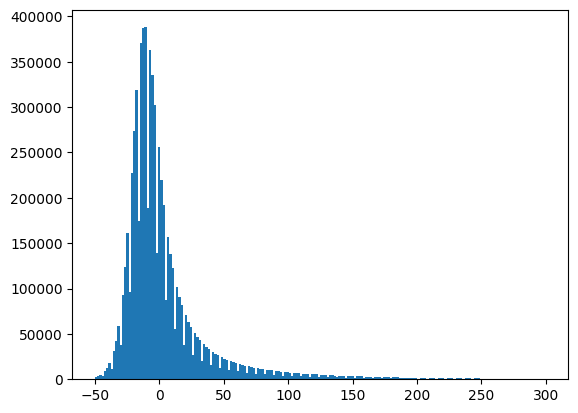

In [9]:
from matplotlib import pyplot as plt

plt.hist(df["arr_delay"], range=(-50, 300), bins=200)
plt.show()

Modelling the relation between arr_delay and dep_delay

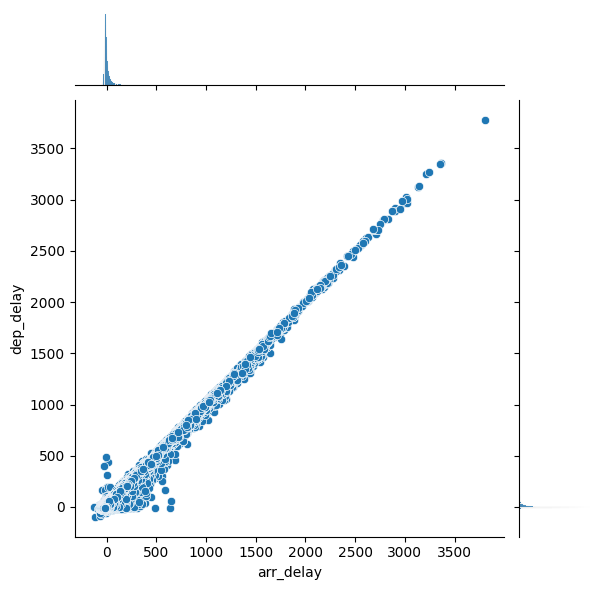

In [10]:
import seaborn as sns

sns.jointplot(df, x="arr_delay", y="dep_delay")

**4. Duplicate check**

In [11]:
copy_df = df.drop_duplicates()

len(copy_df) - len(df)

0

No duplicates in data

**5. "Logical" data pruning**

In [15]:
def logical_checks(df):
    issues = {}

    issues['year_invalid'] = df[~df['year'].between(1900, 2100)]
    issues['month_invalid'] = df[~df['month'].between(1, 12)]
    issues['day_of_month_invalid'] = df[~df['day_of_month'].between(1, 31)]
    issues['day_of_week_invalid'] = df[~df['day_of_week'].between(1, 7)]

    for col in ['crs_dep_time','dep_time','wheels_off','wheels_on','crs_arr_time','arr_time']:
        issues[f'{col}_invalid'] = df[~df[col].between(0, 2400)]

    for col in ['taxi_out','taxi_in','crs_elapsed_time','actual_elapsed_time','air_time',
                'distance','carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay']:
        if col == 'distance':
            issues[f'{col}_invalid'] = df[df[col] < 0]
        else:
            issues[f'{col}_invalid'] = df[df[col] < 0]

    issues['cancelled_invalid'] = df[~df['cancelled'].isin([0,1])]
    issues['diverted_invalid'] = df[~df['diverted'].isin([0,1])]

    return {k:v for k,v in issues.items() if not v.empty}

problems = logical_checks(df)
for k, v in problems.items():
    print(k, len(v))

No logical problems found in the dataset